<a href="https://colab.research.google.com/github/ComponentSoftTeam/Mistral-Kubectl-Instruct/blob/main/notebooks/Deep_Learning_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
# Import required libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torchvision
import numpy as np
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Standardize random numbers for reproducibility
torch.manual_seed(0)

In [2]:
# input layer, a single hidden layer, and an output layer
# Define hyperparameters
input_size = 784  # 28x28 pixels
hidden_size = 128
num_classes = 10
batch_size = 100

In [3]:
img = torchvision.datasets.MNIST(root='../data', train=True, download=True)[0]

In [4]:
# Load MNIST dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),   # convert to pytorch tensor
     transforms.Normalize((0.1307,), (0.3081,))  # standardize the values with mean + std
    ]
)


train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


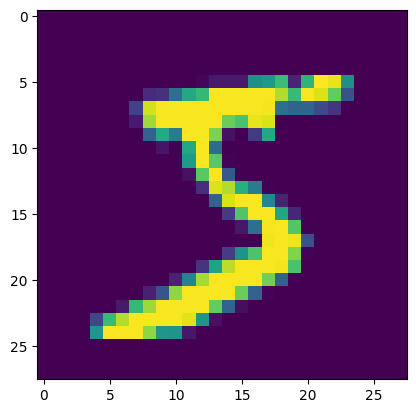

In [5]:
# transpose the array to (28, 28) format expected by Matplotlib
array = np.squeeze(np.transpose(train_dataset[0][0], (1, 2, 0)))

# plot the image using Matplotlib
plt.imshow(array)
plt.show()



In [6]:
next(iter(test_loader))[0].shape

torch.Size([100, 1, 28, 28])

In [7]:
# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Create the model
model = NeuralNet(input_size, hidden_size, num_classes)

In [8]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0294, -0.0263, -0.0138,  ...,  0.0021, -0.0198, -0.0150],
         [-0.0104, -0.0348,  0.0019,  ..., -0.0299, -0.0201,  0.0149],
         [-0.0333, -0.0204,  0.0268,  ...,  0.0080,  0.0160, -0.0330],
         ...,
         [ 0.0085, -0.0147, -0.0222,  ...,  0.0300, -0.0233, -0.0220],
         [-0.0064,  0.0175, -0.0286,  ..., -0.0158,  0.0309,  0.0066],
         [ 0.0125,  0.0280,  0.0030,  ..., -0.0105, -0.0321, -0.0053]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0045, -0.0211,  0.0224,  0.0130,  0.0158,  0.0272,  0.0240, -0.0157,
         -0.0089,  0.0221,  0.0055,  0.0071, -0.0031, -0.0249, -0.0334, -0.0024,
         -0.0124,  0.0129, -0.0047, -0.0190, -0.0051,  0.0227,  0.0324, -0.0356,
          0.0029, -0.0081,  0.0255, -0.0104, -0.0205, -0.0056,  0.0218, -0.0106,
          0.0032,  0.0340, -0.0189, -0.0079, -0.0206, -0.0077, -0.0113,  0.0232,
          0.0032, -0.0164, -0.0082,  0.0203, -0.0323, -0.0244, -0.0152,  0.0348

In [9]:
# Loss function options
cross_entropy_loss = nn.CrossEntropyLoss()
nll_loss = nn.NLLLoss()
mse_loss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
input_size

784

In [11]:
# Function to train the model
def train_model(model, loss_function, train_loader, optimizer, num_epochs=10):
    # Put the model in training mode
    model.train()

    # Iterate over the number of epochs
    for epoch in range(num_epochs):
        # Initialize the running loss for this epoch to zero
        running_loss = 0.0

        # Iterate over each batch in the training loader
        for i, (images, labels) in enumerate(train_loader):

            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)
            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)
            # Compute the loss between the outputs and the true labels
            loss = loss_function(outputs, labels)
            # Backward pass: compute the gradients of the loss with respect to the model parameters
            optimizer.zero_grad()
            loss.backward()
            # Update the model parameters using the optimizer
            optimizer.step()

            # Add the current batch loss to the running loss for this epoch
            running_loss += loss.item()

        # Compute the average loss over all batches for this epoch and print it
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [12]:
# Function to evaluate the model
def evaluate_model(model, test_loader):
    # Put the model in evaluation mode
    model.eval()

    # Initialize empty lists to store true and predicted labels
    y_true, y_pred = [], []

    # Disable gradient computation since we're only evaluating the model
    with torch.no_grad():
        # Iterate over each batch in the test loader
        for images, labels in test_loader:
            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)

            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)

            # Find the predicted class for each image in the batch
            _, predicted = torch.max(outputs.data, 1)

            # Append the true and predicted labels for this batch to the lists
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    # Calculate evaluation metrics using the true and predicted labels
    accuracy, f1, precision, recall = evaluate_model_metrics(np.array(y_true), np.array(y_pred))

    # Return the evaluation metrics
    return accuracy, f1, precision, recall

# Function to calculate evaluation metrics
def evaluate_model_metrics(y_true, y_pred):
    # Compute the accuracy, F1 score, precision, and recall
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    # Return the evaluation metrics
    return accuracy, f1, precision, recall

# Define a dictionary of loss functions
loss_functions = {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
    'NLLLoss': nn.NLLLoss(),  # requires logsoftmax output (according to docs, so loss will be wrong without it!)
    'MultiMarginLoss': nn.MultiMarginLoss()
}

In [13]:
# Train and evaluate the model using different loss functions
for loss_name, loss_function in loss_functions.items():
    print(f'Training with {loss_name}:')

    # Initialize a new model and optimizer for each loss function
    model = NeuralNet(input_size, hidden_size, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, loss_function, train_loader, optimizer, num_epochs=5)

    # Evaluate the model
    accuracy, f1, precision, recall = evaluate_model(model, test_loader)
    print(f'Performance metrics for {loss_name}:')
    print(f'Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n')


Training with CrossEntropyLoss:
Epoch [1/5], Loss: 0.2866
Epoch [2/5], Loss: 0.1266
Epoch [3/5], Loss: 0.0871
Epoch [4/5], Loss: 0.0659
Epoch [5/5], Loss: 0.0518
Performance metrics for CrossEntropyLoss:
Accuracy: 0.9762, F1-score: 0.9761, Precision: 0.9763, Recall: 0.9759

Training with NLLLoss:
Epoch [1/5], Loss: -11701.7112
Epoch [2/5], Loss: -83472.9902
Epoch [3/5], Loss: -217247.0240
Epoch [4/5], Loss: -402067.5901
Epoch [5/5], Loss: -631297.0917


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance metrics for NLLLoss:
Accuracy: 0.1135, F1-score: 0.0204, Precision: 0.0114, Recall: 0.1000

Training with MultiMarginLoss:
Epoch [1/5], Loss: 0.0423
Epoch [2/5], Loss: 0.0156
Epoch [3/5], Loss: 0.0104
Epoch [4/5], Loss: 0.0079
Epoch [5/5], Loss: 0.0064
Performance metrics for MultiMarginLoss:
Accuracy: 0.9716, F1-score: 0.9714, Precision: 0.9722, Recall: 0.9710



# Demo

## Setup

In [53]:
class IterativeRenderer:
  def __init__(self):
    self.chunk_rows = 2
    self.chunk_cols = 8
    self.chunk_size = self.chunk_rows * self.chunk_cols
    self.current_chunk = -1
    self.imgs = None
    self.last_patch = None
    self.fig = None
    self.axes = None
    self.created = False

  def load_img_chunk(self, chunk_index):
    return [(np.squeeze(np.transpose(test_dataset[chunk_index * self.chunk_size + j][0], (1, 2, 0))), test_dataset[chunk_index * self.chunk_size + j][1]) for j in range(self.chunk_size)]

  def render_chunk(self, i):

    self.fig, self.axes = plt.subplots(nrows=self.chunk_rows, ncols=self.chunk_cols, figsize=(self.chunk_cols*2, self.chunk_rows*2))

    chunk_index = i // self.chunk_size
    i = i % self.chunk_size

    if self.last_patch:
      self.last_patch.remove()

    if chunk_index != self.current_chunk:
      imgs = self.load_img_chunk(chunk_index)
      chunk_index = self.current_chunk

      for row in range(self.chunk_rows):
        for col in range(self.chunk_cols):
          index = row * self.chunk_cols + col
          ax = self.axes[row, col]
          img, label = imgs[index]

          ax.imshow(img)
          ax.set_title(f'Label: {label}', fontsize=8)
          ax.axis('off')

          if i == index:
            x0, x1, y0, y1 = ax.axis()
            rec = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, lw=4, edgecolor='cyan')
            self.last_patch = ax.add_patch(rec)
            self.last_patch.set_clip_on(False)

    else:
      chunk_row = i // self.chunk_cols
      chunk_col = i % self.chunk_cols
      ax = self.axes[chunk_row, chunk_col]

      x0, x1, y0, y1 = ax.axis()
      rec = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, lw=4, edgecolor='cyan')
      self.last_patch = ax.add_patch(rec)
      self.last_patch.set_clip_on(False)

    self.fig.tight_layout(pad=2)
    plt.show()

iterative_renderer = IterativeRenderer()

In [89]:
def display_prediction(i, width_limit = 160):
  iterative_renderer.render_chunk(i)
  test = test_dataset[i][0]
  test = test.reshape(-1, input_size)

  prediction = model(test)
  prediction = torch.nn.functional.softmax(prediction, dim=1)[0]

  print("")
  for i, val in enumerate(prediction.tolist()):
    print("{}\t{:.6f} {}".format(i, val, "#"*min(round(width_limit*val), width_limit)))

  print(f"\nmax: \t{torch.max(prediction, 0)[1].item()}")

## Examples

In [94]:
display_index = 16

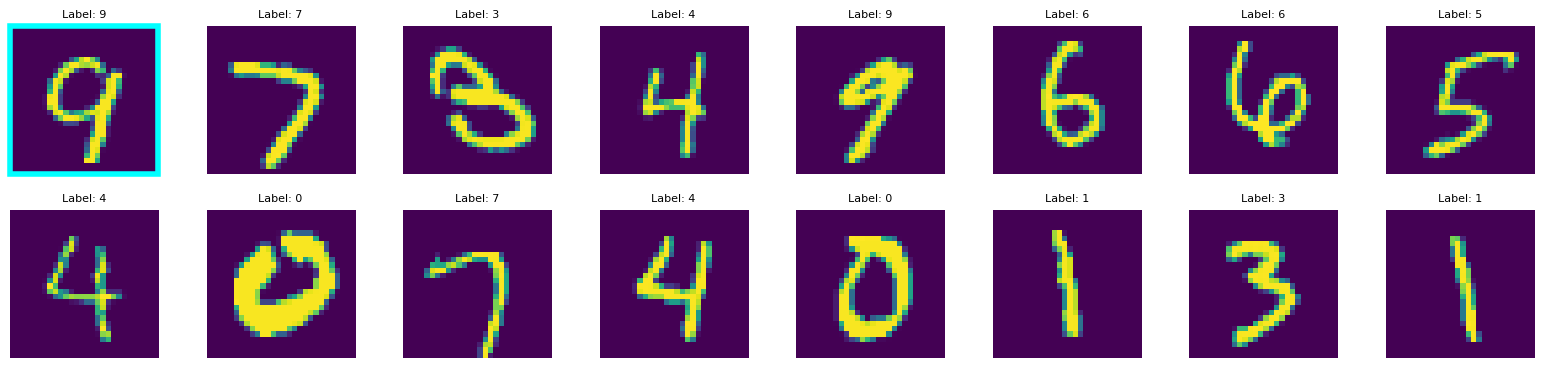


0	0.000365 
1	0.000007 
2	0.000447 
3	0.000153 
4	0.068220 ###########
5	0.000051 
6	0.000082 
7	0.014427 ##
8	0.001299 
9	0.914948 ##################################################################################################################################################

max: 	9


In [95]:
display_prediction(display_index)
display_index += 1